# Conways Spiel des Lebens

![](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)

![](https://upload.wikimedia.org/wikipedia/commons/6/64/Trefoil_knot_conways_game_of_life.gif)

https://de.wikipedia.org/wiki/Conways_Spiel_des_Lebens

## Die Spielregeln

- Eine tote Zelle mit genau drei lebenden Nachbarn wird in der Folgegeneration neu geboren.
- Lebende Zellen mit weniger als zwei lebenden Nachbarn sterben in der Folgegeneration an Einsamkeit.
- Eine lebende Zelle mit zwei oder drei lebenden Nachbarn bleibt in der Folgegeneration am Leben.
- Lebende Zellen mit mehr als drei lebenden Nachbarn sterben in der Folgegeneration an Überbevölkerung.


## Wie programmieren wir es? Teil 1 - die Nachbarn zählen
- für jede Zelle auf einem 2D Grid (der Lebensraum der Zellen) müssen wir die Anzahl ihrer unmittelbaren Nachbarn zählen
- Moore-Nachbarschaft: https://de.wikipedia.org/wiki/Moore-Nachbarschaft

### Das Spielfeld
- 2D `numpy` array
- bei den 2D arrays, kann man sich die erste Dimension (axis=0) als Zeilen und die zweite als Spalten (axis=1) vorstellen
- wenn wir es als Bild darstellen ist (0,0) oben links und die erste Dimension ("Zeilen") ist y, die zweite ("Spalten") ist x

![](https://i.stack.imgur.com/NWTQH.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# irgendein Test Spielfeld
arr = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
])


def show_mat(mat, labels=None):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.matshow(mat, cmap='binary')
    
    if not labels is None:
        if not mat.shape == labels.shape:
            raise ValueError(f"Shape mismatch: {mat.shape} {labels.shape}")
        for y in range(mat.shape[0]):
            for x in range(mat.shape[1]):
                val = mat[y,x]
                c = 'k' if val == 0 else 'w'
                ax.text(x, y, str(labels[y,x]), ha="center", va="center", c=c);
                

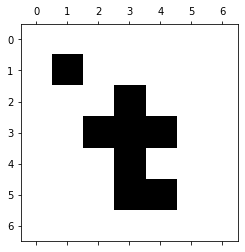

In [3]:
show_mat(arr)

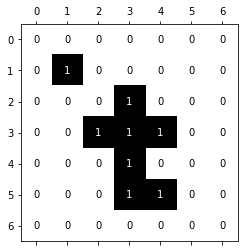

In [5]:
# labels ist eine Matrix mit gleicher Größe (shape) wir unser Spielfeld, 
# die die Anzahl der Nachbarn angibt.
# Da wir die Nachbarn noch nicht gezählt haben, zeigen wir jetzt nur 
# ob die Zelle lebt (Wert 1) oder nicht (Wert 0).
show_mat(arr, labels=arr)

### 1. Iteration: mit der Python `for` Schleife
- gehe jede Zelle durch: für jede Zeile (y) und für jede Spalte (x)
- ...und zähle die Nachbarn:
    - links
    - rechts
    - oben
    - unten
    - oben-links
    - unten-links
    - oben-rechts
    - unten-rechts

**gehe jede Zelle durch**:
```python
for y in range(arr.shape[0]):
    for x in range(arr.shape[1]):
        # x, y -> Koordinaten der aktuellen Zelle
        # arr[y, x] -> Wert der aktuellen Zelle (0 oder 1)
```

**Nachbarn mit indexing finden**:
```python
arr[y, x-1]   # links
arr[y, x+1]   # rechts
arr[y-1, x]   # oben
arr[y-1, x-1] # oben-links
# ...
```

**Probleme**:
- z.B. Nachbarn der Zelle `arr[0,0]`:
    - links:      `arr[0,-1]`
    - oben-links: `arr[-1,-1]`
- in Python Index `-1` ist das letzte Element, `-2` das vorletzten Element, usw. 

```python
np.arange(5)       # array([0, 1, 2, 3, 4])
np.arange(5)[-1]   # 4
np.arange(5)[-2]   # 3
```

- oder bei allen Zellen ganz rechts:
    - rechts: `arr[0,x+1]` ist größer als die Dimension x
    
- müssen diese Eck-Fälle abfangen

In [17]:
# Wegen des oben beschrieben Problems werden wir 
# statt Array Indexing mit arr[y,x] eigene Funktion benutzen
def at_index(arr, idy, idx):
    if idx == -1 or idy == -1:
        return 0
    elif (idx > arr.shape[1] - 1) or (idy > arr.shape[0] - 1):
        return 0
    else:
        return arr[idy, idx]
    

# Nachbarn zählen mit for-Schleife
# Kann auch für Von-Neumann-Nachbarschaft benutzt werden: 
# https://de.wikipedia.org/wiki/Von-Neumann-Nachbarschaft
def count_adjacent_python(arr, diagonal=True):
    res = np.zeros_like(arr)
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            left_idx = x - 1
            right_idx = x + 1
            above_idx = y - 1
            below_idx = y + 1
            
            l = at_index(arr, y, left_idx)
            r = at_index(arr, y, right_idx)
            a = at_index(arr, above_idx, x)
            b = at_index(arr, below_idx, x)
           
            res[y, x] = l + r + a + b
                
            if diagonal:
                la = at_index(arr, above_idx, left_idx)
                lb = at_index(arr, below_idx, left_idx)
                ra = at_index(arr, above_idx, right_idx)
                rb = at_index(arr, below_idx, right_idx)
                
                res[y, x] += la + lb + ra + rb
            
    return res

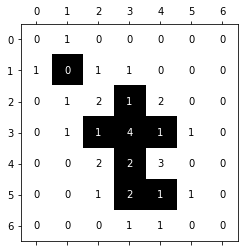

In [18]:
n_adjacent = count_adjacent_python(arr, diagonal=False)
show_mat(arr, n_adjacent)

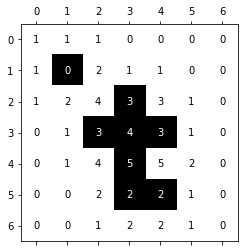

In [19]:
n_adjacent = count_adjacent_python(arr, diagonal=True)    
show_mat(arr, n_adjacent)

### Großes Spielfeld

In [20]:
def random_mat(shape=(7,7), fraction=.3):
    res = np.zeros(shape)
    n_ones = int(fraction * res.size)
    idx = np.random.randint(0, shape[1], size=n_ones)
    idy = np.random.randint(0, shape[0], size=n_ones)
    
    res[idy, idx] = 1
    
    return res


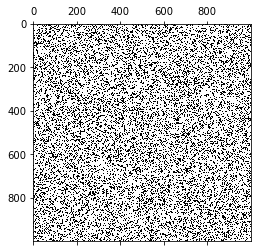

In [21]:
shape = (1000, 1000)
large_arr = random_mat(shape=shape)

show_mat(large_arr)

### Performance

In [39]:
%%timeit
count_adjacent_python(large_arr, diagonal=True)

5.03 s ± 55.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**die Python for-Schleifen sind notorisch zu langsam!!!**

### 2. Iteration: mit `numpy`
- "array computing": https://en.wikipedia.org/wiki/Array_programming
- Rechen-Operationen an ganzen arrays statt an einzelnen Elementen ausführen ("vektorisierte Operation") 
- Vermeiden von `for` Schleifen


#### Das Zählen von Nachbarn als eine Array-Operation - wie geht das? 

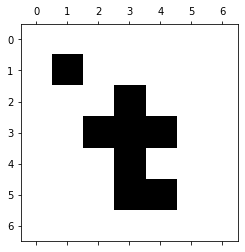

In [22]:
show_mat(arr)

#### Idee
Alle **rechte** Nachbarn für alle Zellen:
- verschiebe alle Zellen nach links und erfasse die Werte (0 kein Nachbar, 1 ein Nachbar)
- die Zellen am rechten Rand bekommen einen Wert 0

ähnlich für **links**, **oben**,..., **links-oben**,...

- starte mit einem array mit 0 Werten und addiere verschobene Versionen von dem Spielfeld:

```python
n_adjacent = np.zeros_like(arr)
n_adjacent += shift_felt(arr) + shift_right(arr) + ...
```


In [23]:
# Stellen wir uns vor, diese Funktion ist in `numpy`
# bereits implementiert. Es reicht zu wissen, was sie 
# macht, nicht wie sie das macht..
#
# Diese Funktion verschiebt alle Elemente eines Array
# in die angegebene Richtung:
#   rechts:      dx =  1
#   links:       dx = -1
#   oben-rechts: dx =  1, dy = -1  
#
def shift(arr, dx=0, dy=0):
    def _axis(d):
        if d == 1:
            before_after = (1, 0)
        elif d == -1:
            before_after = (0, 1)
        elif d == 0:
            before_after = (0, 0)
        return before_after
    
    axis_x = _axis(dx)
    axis_y = _axis(dy)
    padded = np.pad(arr, (axis_y, axis_x), mode='constant')
    
    from_x, to_x = 0 + axis_x[1], padded.shape[1] - axis_x[0]
    from_y, to_y = 0 + axis_y[1], padded.shape[0] - axis_y[0]
    
    return padded[from_y:to_y, from_x:to_x] 
    


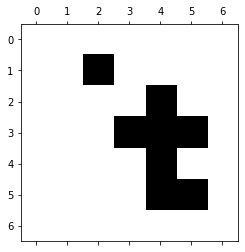

In [26]:
# Verschieben -> probiere verschieden dx, dy Werte (zulässing 0,1,-1)
show_mat(shift(arr, dx=1, dy=0))

In [27]:
# unsere numpy Lösung
def count_adjacent_numpy(arr, diagonal=True):
    
    n_adjacent = np.zeros_like(arr)
    
    # shift left, right, up & down
    n_adjacent += shift(arr, dx=-1) + shift(arr, dx=1) + shift(arr, dy=-1) + shift(arr, dy=1)
    
    if diagonal:
        # shift diagonally
        n_adjacent += shift(arr, dx=-1, dy=-1) + shift(arr, dx=1, dy=1) + shift(arr, dx=1, dy=-1) + shift(arr, dx=-1, dy=1)
        
    return n_adjacent


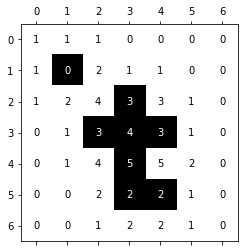

In [28]:
n_adjacent = count_adjacent_numpy(arr)    
show_mat(arr, n_adjacent)

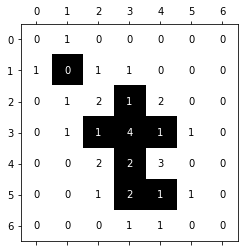

In [29]:
n_adjacent = count_adjacent_numpy(arr, diagonal=False)    
show_mat(arr, n_adjacent)

### Lösungen identisch???

In [35]:
print(count_adjacent_python(arr) == count_adjacent_numpy(arr))
np.all(count_adjacent_python(arr) == count_adjacent_numpy(arr))

[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]


True

In [36]:
print(count_adjacent_python(arr, diagonal=False) == count_adjacent_numpy(arr, diagonal=False))
np.all(count_adjacent_python(arr, diagonal=False) == count_adjacent_numpy(arr, diagonal=False))

[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]


True

### Performance: `numpy`


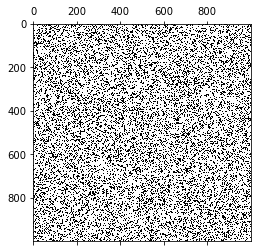

In [37]:
show_mat(large_arr)

In [40]:
%%timeit
count_adjacent_numpy(large_arr, diagonal=True)

25.8 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
# diese Werte werden unterschiedlich sein
took_python_ms = 5000
took_numpy_ms = 26
numpy_faster = int(took_python_ms/took_numpy_ms)

In [43]:
from IPython.display import HTML

HTML(f'<p><font size="6">Numpy <span style="color:red"><b>{numpy_faster}</b></span>'
     ' schneller für eine 1000x1000 Matrix als Python for-Schleife!!!</font></p>')